# Download the data and convert it to netCDF

The original data is provided in the supplementary material of the paper as a text file of longitude, latitude, Moho depth, and uncertainty. It's much easier to work with the gridded data if it's stored in netCDF instead.

## Import things

In [23]:
import datetime
import numpy as np
import xarray as xr
import pooch
import pygmt

## Download

We'll download the data using [Pooch](https://github.com/fatiando/pooch). It will be saved to a cache folder on your computer that it's only downloaded once, even if you run this code many times.

In [2]:
url = "https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2018JB016593&file=jgrb53251-sup-0003-Data_Set_SI-S03.txt"
# Pretent to be a browser so AGU lets us download the file
headers = {'User-Agent': 'Mozilla/5.0'}
fname = pooch.retrieve(
    url, 
    known_hash="sha256:1a8654f3b8f0821b30a1f1fc63034450c37b282e9f2016f14b075853e305b13e", 
    fname="szwillus-moho-depth.txt",
    downloader=pooch.HTTPDownloader(headers=headers)
)

## Read

Read in the data using numpy.

In [8]:
header_lines = []
with open(fname, encoding="latin1") as data_file:
    for line in data_file:
        if line.startswith("#"):
            header_lines.append(line[1:].strip())
header = '\n'.join(header_lines)
print(header)

Depth to Moho boundary obtained by global non-stationary kriging of USGS GSC database of crustal studies
Version (May 7th 2018)
===
Author
===
Wolfgang Szwillus, Kiel University
wolfgang.szwillus@ifg.uni-kiel.de
===
Description
===
Column 1: Longitude
Column 2: Latitude
Column 3: Depth to Moho (km), measured from 0
Column 4: Estimated uncertainty of Moho depth (km)
===
Method
===
I classified the points from the GSC database (Mooney 2007, updated 2016) as either oceanic or continental according to
the ocean floor age grid by Müller et al. (2008). Kriging was carried out for each category
completely independently.
For the Kriging prodecure I used a spherical semivariogram with nugget effect. The data base points are clustered into groups
and each cluster is assigned its own nugget, sill and range parameter. Between clusters the parameters are interpolated using
a form of inverse distance weighting (see Risser and Calder 2017 for details). All calculations are carried out in spherical
co

In [11]:
longitude, latitude, moho_depth, uncertainty = np.loadtxt(fname, encoding="latin1", unpack=True)

In [15]:
shape = (180, 360)

In [22]:
dims = ("latitude", "longitude")
data = xr.Dataset(
    data_vars={
        "moho_depth": (dims, moho_depth.reshape(shape)),
        "uncertainty": (dims, uncertainty.reshape(shape))
    },
    coords={
        "longitude": longitude.reshape(shape)[0, :],
        "latitude": latitude.reshape(shape)[:, 0],
    }
)
data.attrs = {
    "Conventions": "CF-1.8",
    "title": header_lines[0],
    "crs": "WGS84",
    "source": (
        "Converted to netCDF from Szwillus et al. (2019) "
        "https://doi.org/10.1029/2018JB016593"
    ),    
    "license": "Unknown",
    "references": "https://doi.org/10.1029/2018JB016593",
    "history": (
        f"{datetime.datetime.now().astimezone().isoformat(timespec='seconds')} : "
        "Converted original text file to netCDF."
    ),
    "description": header,
    "grid_registration": "pixel",
}
data.moho_depth.attrs = {
    "long_name": "Moho depth",
    "units": "km",
    "actual_range": (data.moho_depth.values.min(), data.moho_depth.values.max()),
    "ancillary_variables": "uncertainty",
    "description": header_lines[0],
}
data.uncertainty.attrs = {
    "long_name": "Moho depth uncertainty",
    "units": "km",
    "actual_range": (data.uncertainty.values.min(), data.uncertainty.values.max()),
    "description": "Estimated uncertainty of the Moho depth",
}
data.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (0, 360),
}
data.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (-90, 90),
}
data

<xarray.Dataset>
Dimensions:      (latitude: 180, longitude: 360)
Coordinates:
  * longitude    (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
Data variables:
    moho_depth   (latitude, longitude) float64 13.52 13.53 13.55 ... 36.65 36.65
    uncertainty  (latitude, longitude) float64 6.41 6.4 6.4 ... 5.68 5.68 5.68
Attributes:
    Conventions:        CF-1.8
    title:              Depth to Moho boundary obtained by global non-station...
    crs:                WGS84
    source:             Converted to netCDF from Szwillus et al. (2019) https...
    license:            Unknown
    references:         https://doi.org/10.1029/2018JB016593
    history:            2020-10-31T06:44:34+00:00 : Converted original text f...
    description:        Depth to Moho boundary obtained by global non-station...
    grid_registration:  pixel

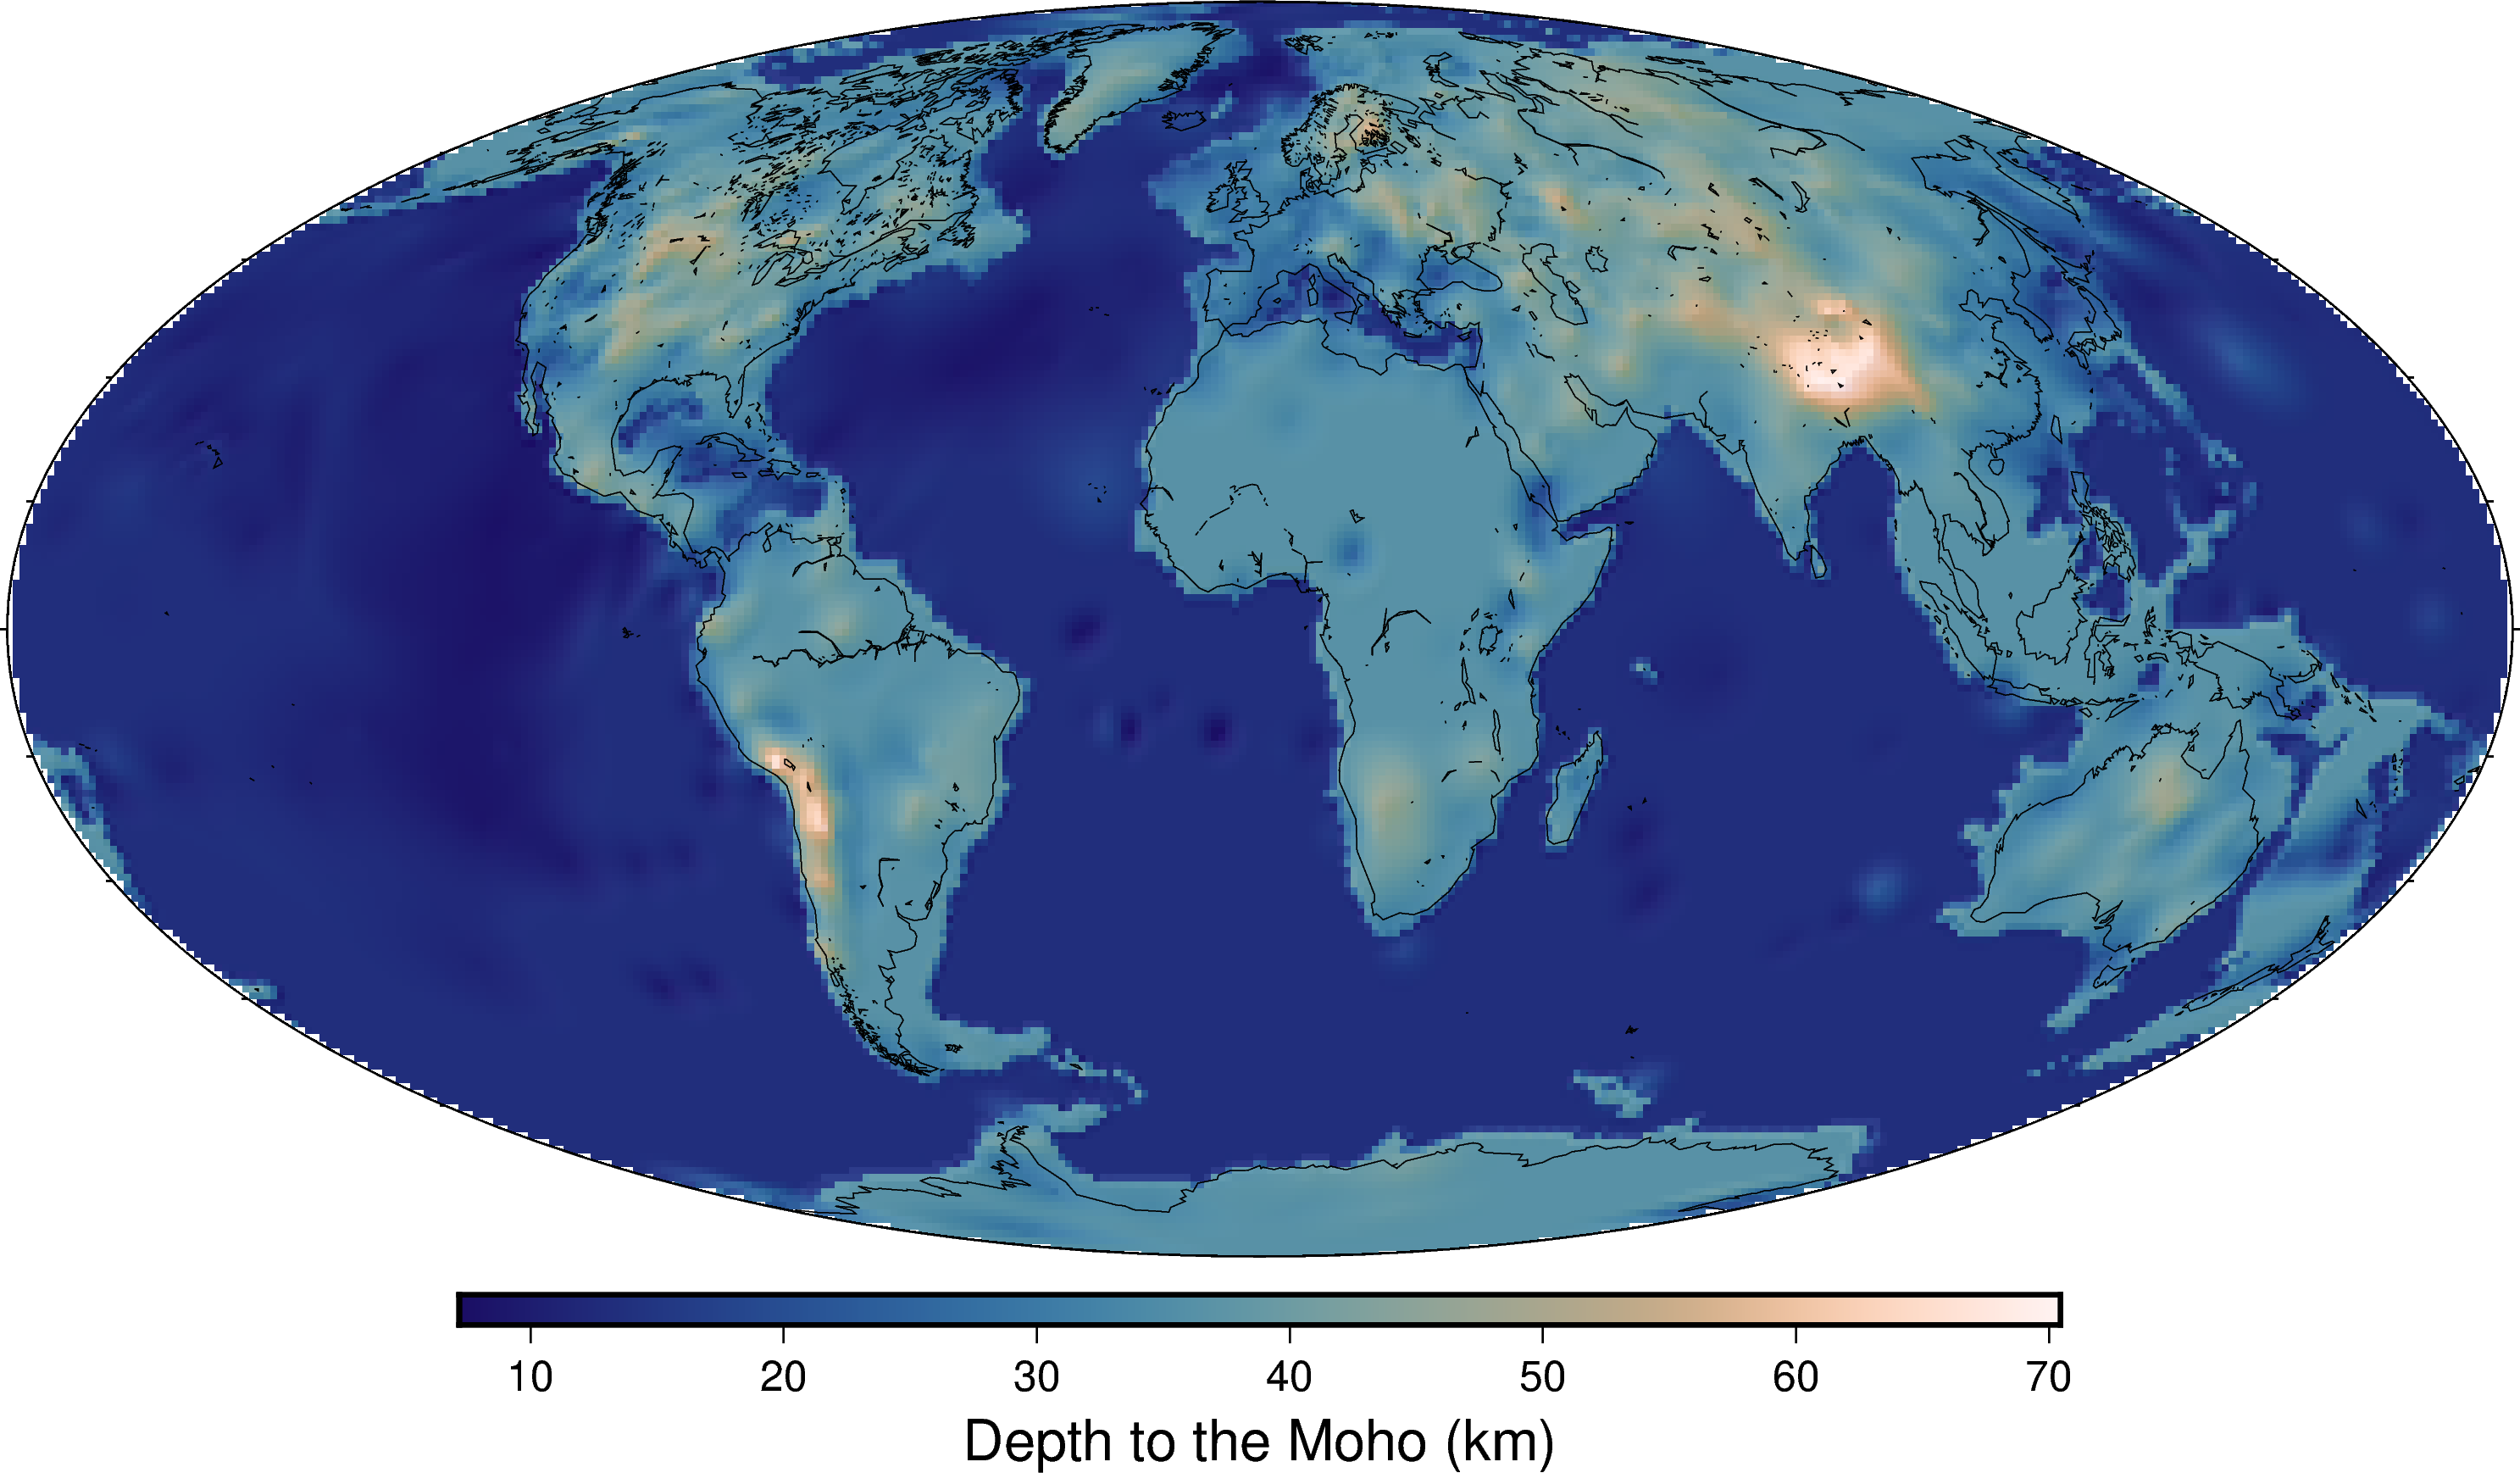

In [77]:
fig = pygmt.Figure()
fig.basemap(region="g", projection="W0/25c", frame="f")
pygmt.makecpt(cmap="lapaz", series=data.moho_depth.attrs["actual_range"])
fig.grdimage(data.moho_depth, cmap=True, shading="+ne0.1")
fig.colorbar(
    position="JBC+h+w16c/0.3c+o0c/0.4c", 
    frame='x10+l"Depth to the Moho (km)"'
)
fig.coast(shorelines=True)
fig.savefig("szwillus-moho-depth.png", dpi=600)
fig.show()